# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.32 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [5]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        #print("Action: ",actions)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        #print("Rewards: ",rewards)
        #print("dones: ",dones)
        #print("States 0: ",next_states[0])
        #print("States 1: ",next_states[1])
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [30]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [8]:
%matplotlib inline

import torch

from ddpg_Multi_Agent import Multi_Agent

from collections import deque
import matplotlib.pyplot as plt
import time, os

In [9]:
maddpg = Multi_Agent(state_size, action_size, num_agents, 0)

In [7]:
scores_max_hist = []
scores_mean_hist = []

def maddpg_train(n_episodes=2000):
    
    scores_deque = deque(maxlen=100)
    
    for i_episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        scores = np.zeros(num_agents)
        maddpg.reset()
        
        while True:
            action = maddpg.act(state, i_episode, add_noise=True)
            env_info = env.step(action)[brain_name]
            
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            
            scores += reward
            
            maddpg.step(i_episode, state, action, reward, next_state, done)
            
            if np.any(done):
                break
                
            state = next_state
            
        score_max = np.max(scores)
        scores_deque.append(score_max)
        score_mean = np.mean(scores_deque)
        
        scores_max_hist.append(score_max)
        scores_mean_hist.append(score_mean)

        print('\r{} episode\tmoving avg score {:.5f}\tmax score {:.5f}'.format(i_episode, np.mean(scores_deque), score_max), end='')
        if score_mean >= 0.5:
            print('\nEnvironment solved after {} episodes with the average score {}\n'.format(i_episode, score_mean))
            maddpg.save()
            
        if i_episode % 50 == 0:
            print()
            
        if i_episode % 10 == 0 and score_mean >= 0.5:
            maddpg.save()
            
        if score_mean >= 1:
            break

In [ ]:
maddpg_train()

0 episode	curr score 0.10000	moving avg score 0.10000	max score 0.10000
100 episode	curr score 0.00000	moving avg score 0.01060	max score 0.00000
200 episode	curr score 0.00000	moving avg score 0.01180	max score 0.00000
300 episode	curr score 0.00000	moving avg score 0.01960	max score 0.00000
400 episode	curr score 0.10000	moving avg score 0.01680	max score 0.10000
500 episode	curr score 0.00000	moving avg score 0.01170	max score 0.00000
600 episode	curr score 0.00000	moving avg score 0.06290	max score 0.00000
700 episode	curr score 0.10000	moving avg score 0.10490	max score 0.10000
800 episode	curr score 0.10000	moving avg score 0.14770	max score 0.10000
900 episode	curr score 0.10000	moving avg score 0.32160	max score 0.10000
941 episode	curr score 2.20000	moving avg score 0.52160	max score 2.20000
Environment solved after 941 episodes with the average score 0.5216000077873468

990 episode	curr score 1.00000	moving avg score 1.11750	max score 1.00000

In [8]:
maddpg_train()

0 episode	moving avg score 0.00000	max score 0.00000
50 episode	moving avg score 0.02627	max score 0.00000
100 episode	moving avg score 0.01920	max score 0.00000
150 episode	moving avg score 0.01660	max score 0.00000
200 episode	moving avg score 0.02250	max score 0.00000
250 episode	moving avg score 0.01860	max score 0.00000
300 episode	moving avg score 0.01090	max score 0.00000
350 episode	moving avg score 0.01270	max score 0.00000
400 episode	moving avg score 0.01430	max score 0.00000
450 episode	moving avg score 0.01330	max score 0.00000
500 episode	moving avg score 0.01670	max score 0.00000
550 episode	moving avg score 0.02750	max score 0.00000
600 episode	moving avg score 0.04800	max score 0.10000
650 episode	moving avg score 0.06410	max score 0.00000
700 episode	moving avg score 0.07090	max score 0.10000
750 episode	moving avg score 0.08550	max score 0.10000
800 episode	moving avg score 0.10600	max score 0.10000
850 episode	moving avg score 0.12170	max score 0.09000
900 episode	m

1156 episode	moving avg score 1.02130	max score 2.40000
Environment solved after 1156 episodes with the average score 1.021300015244633



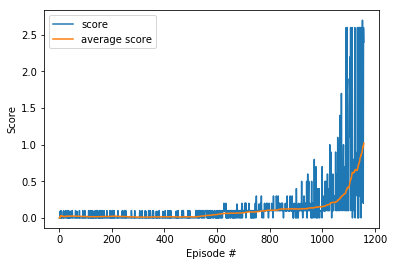

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(np.arange(1, len(scores_max_hist)+1), scores_max_hist, label='score')
plt.plot(np.arange(1, len(scores_mean_hist)+1), scores_mean_hist, label='average score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

In [12]:
scores_max_hist_test = []
scores_mean_hist_test = []
def maddpg_test(n_episodes=100):
    
    for i_episode in range(n_episodes):
        env_info = env.reset(train_mode=False)[brain_name]
        state = env_info.vector_observations
        scores = np.zeros(num_agents)
        maddpg.reset()
        
        while True:
            action = maddpg.act(state, i_episode, add_noise=False)
            env_info = env.step(action)[brain_name]
            
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            
            scores += reward
            #print(i_episode)
            #maddpg.step(i_episode, state, action, reward, next_state, done)
            #print(reward)
            if np.any(done):
                break
                
            state = next_state
            
        score_max = np.max(scores)
        score_mean = np.mean(scores_deque)
        
        scores_max_hist_test.append(score_max)
        scores_mean_hist_test.append(score_mean)
        
        print('\r{} episode\tmoving avg score {:.5f}\tmax score {:.5f}'.format(i_episode, np.mean(scores_deque), score_max), end='')

In [10]:
for idx, agent in enumerate(maddpg.agents):
    chk_actor_filename = torch.load('checkpoint_agent{}_actor.pth'.format(idx))
    chk_critic_filename = torch.load('checkpoint_critic{}_critic.pth'.format(idx))
    agent.actor_local.load_state_dict(torch.load('checkpoint_agent{}_actor.pth'.format(idx)))
    agent.critic_local.load_state_dict(torch.load('checkpoint_critic{}_critic.pth'.format(idx)))

In [ ]:
scores_max_hist_test = []
scores_mean_hist_test = []
scores_deque = deque(maxlen=100)

for i in range(100):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    maddpg.reset()
    while True:
        #actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
       # actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        #print(scores)
        actions = maddpg.act(states, i, add_noise=False)
        #print("Action: ",actions)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished

        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
            
        score_max = np.max(scores)
        score_mean = np.mean(scores_deque)
        
        scores_max_hist_test.append(score_max)
        scores_mean_hist_test.append(score_mean)
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total score (averaged over agents) this episode: 0.1450000023469329
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 2.595000038854778
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 2.650000039488077
Total score (averaged over agents) this episode: 2.550000037997961
Total score (averaged over agents) this episode: 2.650000039488077
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: 1.5450000232085586
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.6450000097975135
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 2.60

In [11]:
env.close()